# L44 Tweet Emotion Classification Project

In [1]:
# Import everything that will be used
from keras.models import Sequential
from keras.layers import *
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

/Users/zebulon/miniconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Prepare constants
SELECTED_DATA = "semeval"
SELECTED_VECTOR_TYPES = ["fasttext", "affectvec"]

SSEC_TEST_FILENAME = "data/ssec-aggregated/test-combined-0.0.csv"
SSEC_TRAIN_FILENAME = "data/ssec-aggregated/train-combined-0.0.csv"
CROWDFLOWER_FILENAME = "data/crowdflower.csv"
TEC_FILENAME = "data/Jan9-2012-tweets-clean.txt"
SEMEVAL_VAL_FILENAME = "data/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-dev.txt"
SEMEVAL_TEST_FILENAME = "data/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-test-gold.txt"
SEMEVAL_TRAIN_FILENAME = "data/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt"

VECTOR_FILENAMES = {"word2vec" : "vectors/word2vec/GoogleNews-vectors-negative300.bin",
                    "affectvec" : "vectors/AffectVec-v1.0-vectors/AffectVec-data.txt",
                    "fasttext" : "vectors/fasttext/crawl-300d-2M.vec",
                    "glove" : "vectors/glove/glove.twitter.27B.200d.txt"}

TEST_PER, VALID_PER = 0.2, 0.1

## Load Raw Data

Load datasets and split into training and testing sets.

In [3]:
random.seed(1)

if SELECTED_DATA == "crowdflower":
    df = pd.read_csv(CROWDFLOWER_FILENAME)
    df.rename(columns={'sentiment':'emotion', 'content':'tweet'}, inplace=True)
    df['tweet'] = df['tweet'].map(lambda tweet : list(gensim.utils.simple_preprocess(tweet)))
    del df['tweet_id']
    del df['author']

    # Delete tweets labelled with emotions that occur less than 1000 times
    emotions, ccount = np.unique(df.emotion, return_counts=True)
    for emotion, count in zip(emotions, ccount):
        if count < 1500:
            df.drop(df[df['emotion'] == emotion].index, inplace=True)
    
    # Split into train and test
    total_samples = df.shape[0]
    n_test = int(TEST_PER * total_samples)
    n_train = total_samples - n_test
    random_i = random.sample(range(total_samples), total_samples)
    df_train = df.iloc[random_i[:n_train]]
    df_test = df.iloc[random_i[n_train:n_train+n_test]]

elif SELECTED_DATA  == "tec":
    with open(TEC_FILENAME, 'r') as tec_file:
        lines = []
        for line in tec_file:
            components = line.split('::')
            tweet = '::'.join(components[:-1])[20:].strip()
            tweet = list(gensim.utils.simple_preprocess(tweet))
            emotion = components[-1].strip()
            lines.append([tweet, emotion])
    df = pd.DataFrame(lines, columns=["tweet", "emotion"])

    # Split into train and test
    total_samples = df.shape[0]
    n_test = int(TEST_PER * total_samples)
    n_train = total_samples - n_test
    random_i = random.sample(range(total_samples), total_samples)
    df_train = df.iloc[random_i[:n_train]]
    df_test = df.iloc[random_i[n_train:n_train+n_test]]

elif SELECTED_DATA == "ssec":
    def get_df(filename):
        with open(filename, 'r') as file:
            lines = []
            for line in file:
                components = line.split('\t')
                tweet = list(gensim.utils.simple_preprocess("\t".join(components[8:])))
                emotions = [c.lower() for c in components[:8] if c != "---"]
            return pd.DataFrame(lines, columns=["tweet", "emotion"])

    # Get train and test dataframes
    df_test = get_df(SSEC_TEST_FILENAME)
    df_train = get_df(SSEC_TRAIN_FILENAME)
    df = df_test.append(df_train)

elif SELECTED_DATA == "semeval":
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]
    def get_df(filename):
        df = pd.read_csv(filename, sep='\t')
        df.rename(columns={'Tweet':'tweet'}, inplace=True)
        df['emotion'] = ''
        for emotion in emotions:
            df['emotion'] = df['emotion'] + df[emotion].map(lambda r : emotion + ' ' if r else '')
        df['emotion'] = df['emotion'].map(lambda e : e.strip().split(' '))
        df['tweet'] = df['tweet'].map(lambda t : list(gensim.utils.simple_preprocess(t)))
        return df[['tweet', 'emotion']]
    df_test = get_df(SEMEVAL_TEST_FILENAME)
    df_train = get_df(SEMEVAL_TRAIN_FILENAME)
    df_val = get_df(SEMEVAL_VAL_FILENAME)
    df = df_test.append(df_train)
    df = df.append(df_val)

print(df)

                                                 tweet  \
0    [adnan__, asyounotwish, dont, worry, indian, a...   
1    [academy, of, sciences, eschews, the, normally...   
2                       [blew, that, opportunity, mad]   
3                    [this, time, in, weeks, will, be]   
4    [deppression, is, real, partners, depressed, p...   
..                                                 ...   
881  [badhombrenps, secretaryperry, if, this, didn,...   
882  [excited, to, watch, stateoforigin, tonight, c...   
883  [blah, blah, blah, kyrie, it, etc, cjc, boss, ...   
884  [the, wise, shepherd, never, trusts, his, floc...   
885  [am, really, flattered, and, happy, to, hear, ...   

                                    emotion  
0    [anger, anticipation, optimism, trust]  
1                                 [disgust]  
2                 [anger, disgust, sadness]  
3                            [joy, sadness]  
4                           [fear, sadness]  
..                         

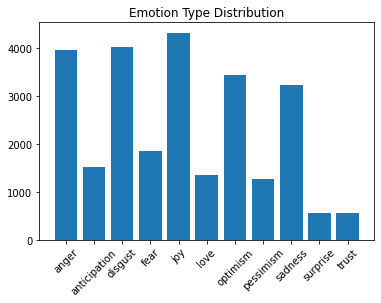

Emotion mapping: {'anticipation': 0, 'pessimism': 1, 'joy': 2, 'optimism': 3, 'love': 4, 'disgust': 5, 'sadness': 6, 'surprise': 7, 'fear': 8, 'anger': 9, 'trust': 10}


In [4]:
# Visualise emotion counts
if SELECTED_DATA == "ssec":
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]
    ccount = [len(df[df['emotion'].map(lambda r : emotion in r)]) for emotion in emotions]
elif SELECTED_DATA == "semeval":
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]
    ccount = [len(df[df['emotion'].map(lambda r : emotion in r)]) for emotion in emotions]
else:
    emotions, ccount = np.unique(df.emotion, return_counts=True)
plt.figure()
plt.title("Emotion Type Distribution")
plt.bar(emotions, ccount, align='center')
plt.xticks(rotation=45)
plt.show()

# Get number of emotions and create a map
n_emotions = len(emotions)
emotion_dict = {e : i for i, e in enumerate(set(emotions))}
print("Emotion mapping: {}".format(emotion_dict))

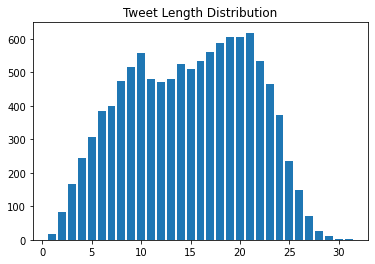

Maximum tweet length: 31


In [5]:
# Visualise tweet lengths
tweet_lengths = df.tweet.map(lambda t: len(t))
lengths, ccount = np.unique(tweet_lengths, return_counts=True)
plt.figure()
plt.title("Tweet Length Distribution")
plt.bar(lengths, ccount, align='center')
plt.show()

max_length = max(lengths)
print("Maximum tweet length: {}".format(max_length))

## Word Embedding Preparation
Load pre-trained word embedding models.

In [6]:
embedding_weights = []
vocab_size, embedding_size = 0, 0
word_to_vector_id = {}

# Load word embedding vectors and append together if more than one selected
first_model = True
for vector_type in SELECTED_VECTOR_TYPES:
    vec_filename = VECTOR_FILENAMES[vector_type]
    vec_model = gensim.models.KeyedVectors.load_word2vec_format(vec_filename, binary=("bin" in vec_filename), no_header=("glove" in vec_filename))
    print("Loaded vectors from:", VECTOR_FILENAMES[vector_type])

    # Update the total size of each embedding
    vec_length = vec_model.vectors.shape[1]
    embedding_size += vec_length

    # Update zeroth vector of embedding weights (not used by embedding layer)
    if first_model:
        embedding_weights = [np.zeros(vec_length)]
    else:
        embedding_weights[0] = np.append(embedding_weights[0], np.zeros((1, vec_length)))

    # Only store the word embeddings required by looping over all words in the dataset
    if first_model:
        for tweet in df["tweet"]:
            for word in tweet:
                if not word in word_to_vector_id:
                    if word in vec_model:
                        embedding_weights.append(vec_model[word])
                        vocab_size += 1
                        word_to_vector_id[word] = vocab_size
                    else:
                        word_to_vector_id[word] = 0 # Map unseen words to 0 (embedding layer masks 0 out)
    else:
        for word in word_to_vector_id:
            if word_to_vector_id[word] == 0:
                continue
            if word in vec_model:
                embedding_weights[word_to_vector_id[word]] = np.append(embedding_weights[word_to_vector_id[word]], vec_model[word])
            else:
                embedding_weights[word_to_vector_id[word]] = np.append(embedding_weights[word_to_vector_id[word]], np.zeros((1, vec_length)))

    del vec_model
    first_model = False
    print("Embeddings loaded.")

embedding_weights = np.array(embedding_weights)
print(embedding_weights)
print(embedding_weights.shape)
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Loaded vectors from: vectors/fasttext/crawl-300d-2M.vec
Embeddings loaded.
Loaded vectors from: vectors/AffectVec-v1.0-vectors/AffectVec-data.txt
Embeddings loaded.
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.27720001  0.0943      0.0701     ...  0.092       0.1203
  -0.0231    ]
 [ 0.1284      0.19400001  0.0745     ...  0.048       0.2368
   0.0653    ]
 ...
 [-0.2516     -0.44069999 -0.34189999 ...  0.0853     -0.087
   0.0915    ]
 [-0.32749999  0.1715     -0.0161     ...  0.069      -0.0873
  -0.0743    ]
 [-0.3777      0.30520001 -0.56       ...  0.          0.
   0.        ]]
(14760, 539)
Vocabulary Size: 14759 - Embedding Dim: 539


## Data Preparation
Convert tweets into token IDs for the embedding layer of the LSTM and prepare datasets for training, validation and testing.

In [7]:
# Convert tweets to token IDs
def get_data_from_df(dataframe):
    set_x, set_y = [], []
    for tweet, emotion in zip(dataframe.tweet, dataframe.emotion):
        #words = np.array([main_model.key_to_index[word] if word in main_model else 0 for word in tweet])
        words = np.array([word_to_vector_id[word] for word in tweet])
        set_x.append(words)
        if SELECTED_DATA in ["ssec", "semeval"]:
            set_y.append([1 if k in emotion else 0 for k in emotion_dict])
        else:
            set_y.append(emotion_dict[emotion])
    set_x = pad_sequences(set_x, maxlen=max_length, padding='pre', value=0)
    set_y = np.array(set_y)
    return set_x, set_y

In [8]:
# Convert train and test dataframes to data and labels
train_x, train_y = get_data_from_df(df_train)
test_x, test_y = get_data_from_df(df_test)

# Get validation data
if SELECTED_DATA == "semeval":
    val_x, val_y = get_data_from_df(df_val)
else:
    n_val = int(VALID_PER * total_samples)
    n_train = set_x.shape[0] - n_val
    val_x = train_x[random_i[n_train:n_train+n_val]]
    val_y = train_y[random_i[n_train:n_train+n_val]]
    train_x = train_x[random_i[:n_train]]
    train_y = train_y[random_i[:n_train]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))
print("Test Shapes - X: {} - Y: {}".format(test_x.shape, test_y.shape))

Train Shapes - X: (6838, 31) - Y: (6838, 11)
Val Shapes - X: (886, 31) - Y: (886, 11)
Test Shapes - X: (3259, 31) - Y: (3259, 11)


## Defining LSTM Model

In [9]:
def prepare_model():

    model = Sequential()

    # Keras Embedding layer with Word2Vec weights initialization
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=embedding_size,
                        weights=[embedding_weights],
                        input_length=max_length,
                        mask_zero=True,
                        trainable=False))

    model.add(LSTM(175, dropout = 0.5, recurrent_dropout = 0.5))
    #model.add(Dense(50, activation='relu'))
    if SELECTED_DATA in ["ssec", "semeval"]:
        model.add(Dense(n_emotions, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(n_emotions, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def train_model():
    return model.fit(train_x, train_y, epochs=8, batch_size=32, validation_data=(val_x, val_y), verbose=1)

def plot_loss_and_accuracy():
    plt.figure(figsize=(12, 12))
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def evaluate():
    # Get predictions of the model
    preds = model.predict(test_x)
    if SELECTED_DATA in ["ssec", "semeval"]:
        preds[preds>=0.5] = 1
        preds[preds<0.5] = 0
    else:
        preds = np.argmax(preds, axis=1)
    scores = []
    total_tp, total_pred, total_gold = 0, 0, 0
    emotions = list(emotion_dict)
    list.sort(emotions)

    # Get precision, recall and F1
    for emotion in emotions:
        if SELECTED_DATA in ["ssec", "semeval"]:
            preds_emotion = preds[:,emotion_dict[emotion]]
            true_emotion = test_y[:,emotion_dict[emotion]]
            total_pred += sum(preds_emotion)
            total_gold += sum(true_emotion)
            total_tp += sum(preds_emotion + true_emotion == 2)
            prec = precision_score(preds_emotion, true_emotion, zero_division=0)
            rec = recall_score(preds_emotion, true_emotion, zero_division=0)
            f1 = f1_score(preds_emotion, true_emotion, zero_division=0)
        else:
            prec = precision_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
            rec = recall_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
            f1 = f1_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
        scores.append([emotion, prec, rec, f1])

    # Get micro-F1 scores
    if SELECTED_DATA in ["ssec", "semeval"]:
        micro_prec = total_tp / total_pred
        micro_rec = total_tp / total_gold
        micro_f1 = (2 * micro_prec * micro_rec) / (micro_prec + micro_rec)
    else:
        micro_prec = precision_score(preds, val_y, average='micro', zero_division=0)
        micro_rec = recall_score(preds, val_y, average='micro', zero_division=0)
        micro_f1 = f1_score(preds, val_y, average='micro', zero_division=0)
    scores.append(["micro", micro_prec, micro_rec, micro_f1])

    # Get macro-F1 scores
    macro_prec = sum([score[1] for score in scores])/len(scores)
    macro_rec = sum([score[2] for score in scores])/len(scores)
    macro_f1 = sum([score[3] for score in scores])/len(scores)
    scores.append(["macro", macro_prec, macro_rec, macro_f1])

    score_df = pd.DataFrame(scores, columns=["Emotion", "Precision", "Recall", "F-Score"])
    print(score_df)
    return score_df

In [10]:
RUNS = 5
score_dfs = []

for i in range(RUNS):
    model = prepare_model()
    train_model()
    score_dfs.append(evaluate())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 539)           7955640   
_________________________________________________________________
lstm (LSTM)                  (None, 175)               500500    
_________________________________________________________________
dense (Dense)                (None, 11)                1936      
Total params: 8,458,076
Trainable params: 502,436
Non-trainable params: 7,955,640
_________________________________________________________________
Epoch 1/8
214/214 [==============================] - 39s 166ms/step - loss: 0.4449 - accuracy: 0.3239 - val_loss: 0.3510 - val_accuracy: 0.3713
Epoch 2/8
214/214 [==============================] - 31s 145ms/step - loss: 0.3425 - accuracy: 0.3279 - val_loss: 0.3270 - val_accuracy: 0.3600
Epoch 3/8
214/214 [==============================] - 40s 189ms/step - loss: 0.3212

In [11]:
print("Individual runs:")
print(score_dfs[0])
print()

score_average = score_dfs[0].copy(deep=True)
score_average["Precision"] /= len(score_dfs)
score_average["Recall"] /= len(score_dfs)
score_average["F-Score"] /= len(score_dfs)

for s in score_dfs[1:]:
    score_average["Precision"] += s["Precision"]/len(score_dfs)
    score_average["Recall"] += s["Recall"]/len(score_dfs)
    score_average["F-Score"] += s["F-Score"]/len(score_dfs)
    print(s)
    print()

print("\nAverage:")
print(score_average)

Individual runs:
         Emotion  Precision    Recall   F-Score
0          anger   0.740236  0.787440  0.763109
1   anticipation   0.047059  0.425532  0.084746
2        disgust   0.707916  0.730516  0.719039
3           fear   0.682474  0.793765  0.733925
4            joy   0.772538  0.876475  0.821231
5           love   0.476744  0.679558  0.560364
6       optimism   0.652668  0.730656  0.689464
7      pessimism   0.117333  0.611111  0.196868
8        sadness   0.546875  0.801527  0.650155
9       surprise   0.064706  0.647059  0.117647
10         trust   0.039216  0.400000  0.071429
11         micro   0.775640  0.589147  0.669652
12         macro   0.468617  0.672732  0.506469


Average:
         Emotion  Precision    Recall   F-Score
0          anger   0.740236  0.787440  0.763109
1   anticipation   0.047059  0.425532  0.084746
2        disgust   0.707916  0.730516  0.719039
3           fear   0.682474  0.793765  0.733925
4            joy   0.772538  0.876475  0.821231
5           